In [1]:
import pandas as pd
import numpy as np
import math

from datetime import datetime, timedelta
from datetime import datetime, timezone
from dateutil.tz import tzutc, tzlocal

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

from scipy import stats


In [3]:
start_date = '2020-03-27 00:00'

#read model and round time down
model = pd.read_excel('stflo_val.xlsx')

model['Time'] = model['Time'].apply(np.floor)

StartDateTime = datetime.strptime(start_date, '%Y-%m-%d %H:%M')
model["date"] = model["Time"].apply(lambda x: StartDateTime + timedelta(minutes=x))

model.set_index('date', inplace =True)





USGS_stht = pd.read_csv('Hanalei_stream_16104200.csv')
USGS_stht['datetime'] = pd.to_datetime(USGS_stht['datetime'])
# hawaii time is -10 hours from standard GMT time
Hawaii_time = timezone(timedelta(hours = -10, minutes = 0))

#set the datetime to a local timestamp for hawaii (gmt -10 hours)
for i in range(len(USGS_stht)):
    USGS_stht['datetime'][i] = USGS_stht['datetime'][i].astimezone(Hawaii_time)
for i in range(len(USGS_stht)):
    USGS_stht.datetime[i] = USGS_stht.datetime[i].replace(tzinfo=None)

C:\Users\bgorb\AppData\Local\Temp\ipykernel_20472\223553104.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  USGS_stht['datetime'][i] = USGS_stht['datetime'][i].astimezone(Hawaii_time)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_20472\223553104.py:24: FutureWarning: Setitem-like behavior with mismatched timezones is deprecated and will change in a future version. Instead of raising (or for Index, Series, and DataFrame methods, coercing to object dtype), the value being set (or passed as a fill_value, or inserted) will be cast to the existing DatetimeArray/DatetimeIndex/Series/DataFrame column's timezone. To retain the old behavior, explicitly cast to object dtype before the operation.
  USGS_stht['datetime'][i] = USGS_stht['datetime'][i].astimezone(Hawaii_time)


In [4]:
#read streamflow file

df_obs = USGS_stht[['datetime', 'metric_height_m' ]].copy()
df_obs =  df_obs.set_index('datetime')
df_obs.index = pd.to_datetime(df_obs.index)

#merge the observed streamflow to the modeled streamflow on the date index
merged = pd.merge(model, df_obs, how = 'inner', left_index = True, right_index = True)

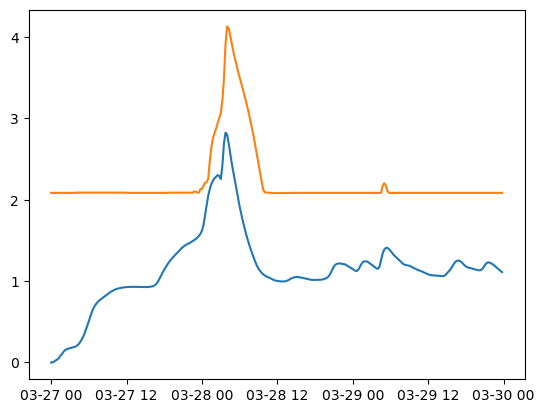

In [5]:
plt.plot(merged.index, merged.depth)
plt.plot(merged.index, merged.metric_height_m)

In [6]:
merged.metric_height_m.mean() / merged.depth.mean()

1.9385526809878229

In [7]:
height_corr = []
for i in merged.depth:
    height_corrected = i + (merged.metric_height_m.mean() - merged.depth.mean())
    height_corr.append(height_corrected)
merged['height_corr'] = height_corr 

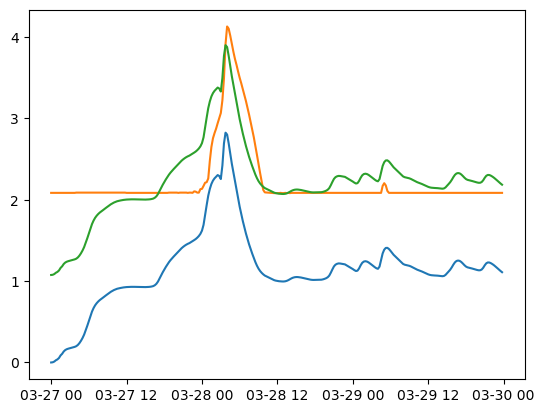

In [8]:
merged
plt.plot(merged.index, merged.depth)
plt.plot(merged.index, merged.metric_height_m)
plt.plot(merged.index, merged.height_corr)

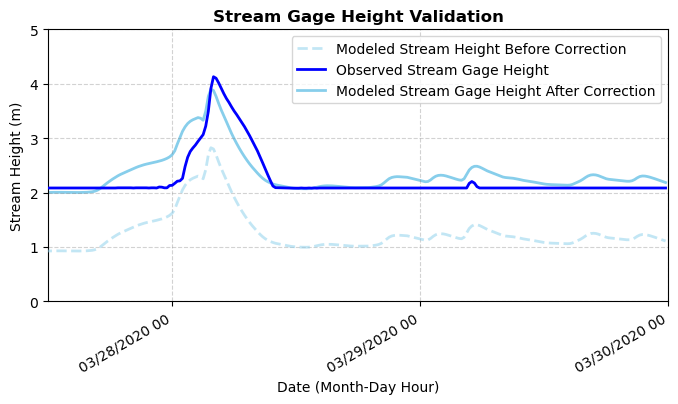

In [9]:
#creat subplot
fig, ax = plt.subplots(figsize=(8,4))

#make the dates look diagonal and pretty
fig.autofmt_xdate()

#create two plots the ',' is for used on the legend
a, = ax.plot(merged.index, merged.depth, linewidth = 2,linestyle = '--', zorder = 4, alpha = 0.5, c = 'skyblue')
b, = ax.plot(merged.index, merged.metric_height_m, linewidth = 2, zorder = 3, alpha = 1, c= 'blue') #marker ='.', c='lime', edgecolor='black', linewidth = 0.5, s=40)
c, = ax.plot(merged.index, merged.height_corr, linewidth = 2, zorder = 1, alpha = 1,c = 'skyblue')

#create a pretty grid
plt.rc('axes', axisbelow=True)
ax.grid(True, color='gray', linestyle='dashed', alpha = 0.35)

#set x axis to margins and y axis to 0-650
ax.margins(x=0)
ax.set_ylim([0, 5])

#add legend, lebels, and text
ax.legend([a, b, c], ['Modeled Stream Height Before Correction','Observed Stream Gage Height', 'Modeled Stream Gage Height After Correction'])
ax.set_title('Stream Gage Height Validation', fontweight="bold")
ax.set_xlabel('Date (Month-Day Hour)')
ax.set_ylabel('Stream Height (m)')
#ax.text(0.023, 0.78, '\nRMSE: ' + str(rmse) + '\nNSE: ' + str(nse), size=9, ha="left", 
         #transform=ax.transAxes,
       #bbox=dict(facecolor='white'))
#ax.set_ylim(0, df_roughness_only[0]['metric_discharge_cms'].max() +100)
ax.set_xlim(pd.to_datetime('03-27-2020 12:00'), pd.to_datetime('03-30-2020'))

#configure datetime axis

hours = mdates.HourLocator(interval = 1)
myFmt = DateFormatter("%m-%d-%y %H")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y %H'))
ax.xaxis.set_major_locator(mdates.DayLocator())

#save figure
#plt.savefig('AGU.png')


In [10]:
def RMSE(merged_dataframe):
    Oi = np.array(list(merged_dataframe.metric_discharge_cms))
    Pi = np.array(list(merged_dataframe.WMS_cms))
    n = len(Oi)
    
    RMSE = math.sqrt( np.sum( (Oi - Pi)**2 ) / n  )
    return round(RMSE, 2)

def PBIAS(merged_dataframe):
    Oi = np.array(list(merged_dataframe.metric_discharge_cms))
    Pi = np.array(list(merged_dataframe.WMS_cms))
    
    PBIAS = (( np.sum(Oi - Pi) ) / np.sum(Oi))*100
    return round(PBIAS, 2)

def NSE(merged_dataframe):
    Oi = np.array(list(merged_dataframe.metric_discharge_cms))
    Pi = np.array(list(merged_dataframe.WMS_cms))
    O_bar = np.mean(Oi)
    
    NSE = 1 - ( np.sum( (Oi - Pi)**2 )  /  np.sum( (Oi - O_bar)**2 ) )
    return round(NSE, 2)

def max_streamflow_percent_error(merged_dataframe):
    Oi = np.array(list(merged_dataframe.metric_discharge_cms))
    Pi = np.array(list(merged_dataframe.WMS_cms))
    Oi_max = np.max(Oi)
    Pi_max = np.max(Pi)
    
    PE = (( Pi_max - Oi_max) / Oi_max)*100
    return round(PE, 2)

def max_streamflow_timing_difference(merged_dataframe):
    Oi = list(merged_dataframe.metric_discharge_cms)
    Pi = list(merged_dataframe.WMS_cms)
    Oi_max = max(Oi)
    Pi_max = max(Pi)
    Oi_max_index = Oi.index(Oi_max)
    Pi_max_index = Pi.index(Pi_max)
    
    date_time = merged_dataframe.index
    Oi_max_time = date_time[Oi_max_index]
    Pi_max_time = date_time[Pi_max_index]
    
    time_dif = (Pi_max_time - Oi_max_time) / pd.Timedelta(hours = 1)
    return round(time_dif, 2)

def KSE(merged_dataframe):
    Oi = np.array(list(merged_dataframe.metric_discharge_cms))
    Pi = np.array(list(merged_dataframe.WMS_cms))
    O_std = np.std(Oi)
    P_std = np.std(Pi)
    O_mean = np.mean(Oi)
    P_mean = np.mean(Pi)
    r = stats.pearsonr(Oi, Pi)[0]
    KSE = 1 - math.sqrt((r-1)**2 + ((P_std/O_std) - 1)**2 + (P_mean / O_mean)**2)
    return round(KSE, 2)

In [11]:
merged['metric_discharge_cms'] = merged.metric_height_m
merged['WMS_cms'] = merged.height_corr

In [12]:
NSE(merged)

0.21